# Chapter 16 Exercises

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In the previous chapter’s exercises, you built LSTM models. Now you’ll experiment
with a CNN and a combination of CNN and LSTM to see if you can gain in performance. 

For the single-step model:

    a Build a CNN model. Set the kernel width to 3.
    b Plot its predictions.
    c Evaluate the model using the mean absolute error (MAE) and store the MAE.
    d Build a CNN + LSTM model.
    e Plot its predictions.
    f Evaluate the model using the MAE and store the MAE.
    g Which model performs best?

For the multi-step model:

    a Build a CNN model. Set the kernel width to 3.
    b Plot its predictions.
    c Evaluate the model using the MAE and store the MAE.
    d Build a CNN+LSTM model.
    e Plot its predictions.
    f Evaluate the model using the MAE and store the MAE.
    g Which model performs best?

Multi-output model:

    a Build a CNN model. Set the kernel width to 3.
    b Plot its predictions.
    c Evaluate the model using the MAE and store the MAE.
    d Build a CNN + LSTM model.
    e Plot its predictions.
    f Evaluate the model using the MAE and store the MAE.
    g Which model performs best?

In [6]:
train_df = pd.read_csv('data/ex_train.csv')
val_df = pd.read_csv('data/ex_val.csv')
test_df = pd.read_csv('data/ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [7]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [9]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Single-step model 

### CNN

#### Build a CNN model. Set the kernel width to 3 

In [13]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['NO2'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['NO2'])

In [14]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.0047 - mean_absolute_error: 0.0437 - val_loss: 0.0021 - val_mean_absolute_error: 0.0308
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0300 - val_loss: 0.0020 - val_mean_absolute_error: 0.0292
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0282 - val_loss: 0.0020 - val_mean_absolute_error: 0.0293
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0283 - val_loss: 0.0019 - val_mean_absolute_error: 0.0276
Epoch 5/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0280 - val_loss: 0.0019 - val_mean_absolute_error: 0.0284
Epoch 6/50
414/414 [==============================] - 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0276 - val_loss: 0.0020 - val_mean_absolute_error: 0.0302
Epoch 7/50
414/4

#### Plot its predictions

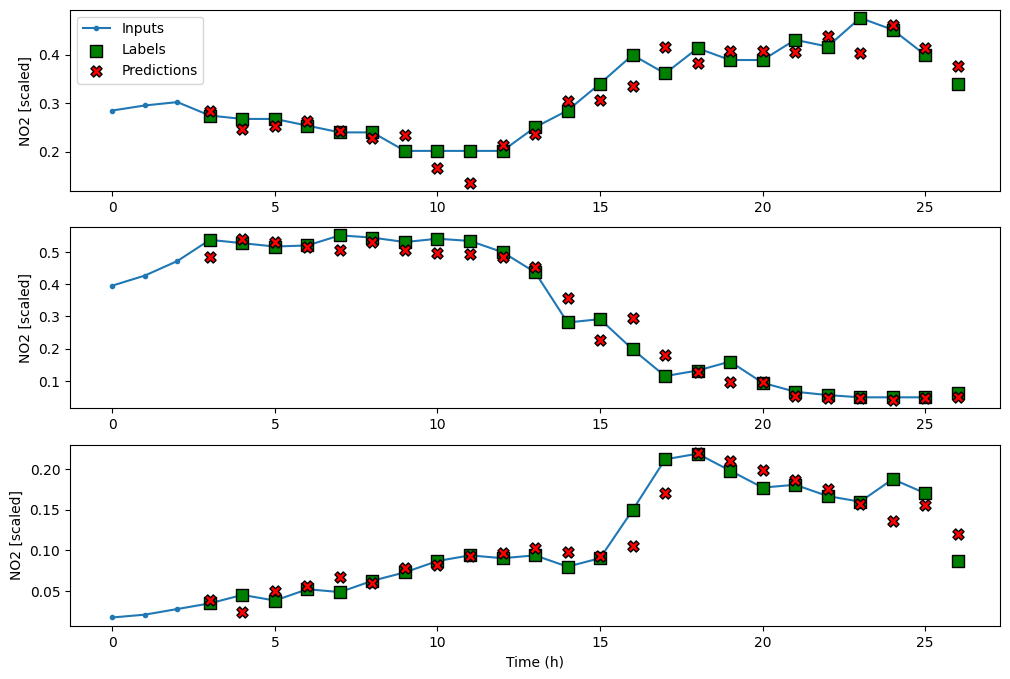

In [16]:
wide_conv_window.plot(cnn_model)

### CNN + LSTM 

In [18]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
414/414 [==============================] - 11s 9ms/step - loss: 0.0058 - mean_absolute_error: 0.0501 - val_loss: 0.0021 - val_mean_absolute_error: 0.0313
Epoch 2/50
414/414 [==============================] - 2s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0296 - val_loss: 0.0020 - val_mean_absolute_error: 0.0304
Epoch 3/50
414/414 [==============================] - 3s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0286 - val_loss: 0.0021 - val_mean_absolute_error: 0.0315
Epoch 4/50
414/414 [==============================] - 2s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0280 - val_loss: 0.0022 - val_mean_absolute_error: 0.0325
Epoch 5/50
414/414 [==============================] - 2s 6ms/step - loss: 0.0016 - mean_absolute_error: 0.0272 - val_loss: 0.0018 - val_mean_absolute_error: 0.0281
Epoch 6/50
414/414 [==============================] - 2s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0271 - val_loss: 0.0019 - val_mean_absolute_error: 0.0279
Epoch 7/50
414/

####  Plot its predictions

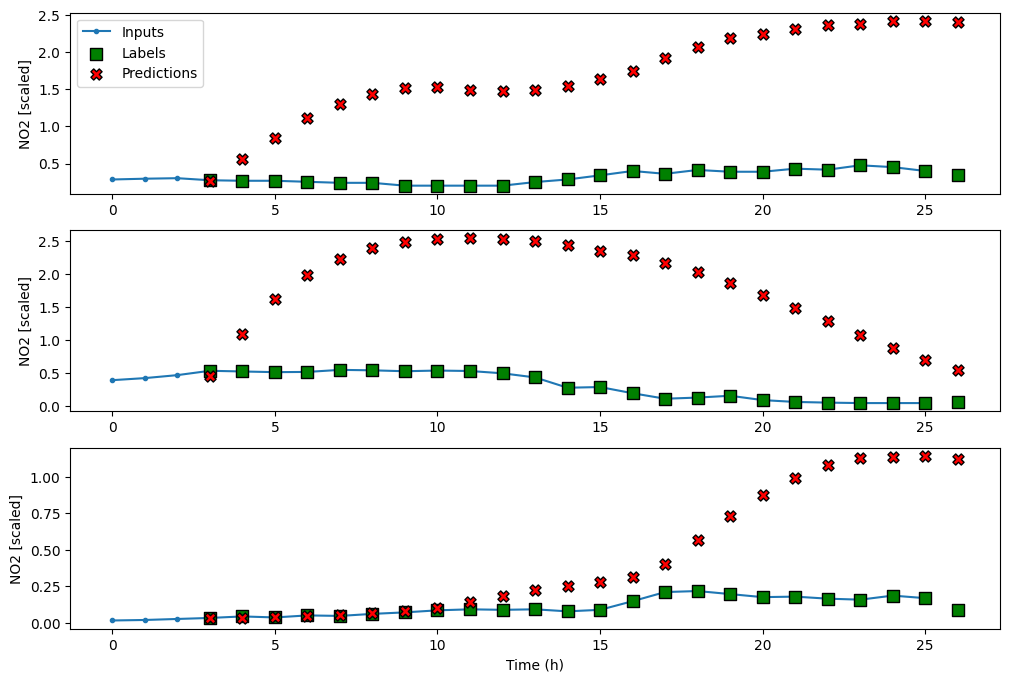

In [20]:
wide_conv_window.plot(cnn_lstm_model)

#### Evaluate the model using the MAE and store the MAE

In [22]:
# Values obtained from chapter 15

mae_val = [0.029, 0.028, 0.029, 0.027]
mae_test = [0.033, 0.032, 0.034, 0.033]

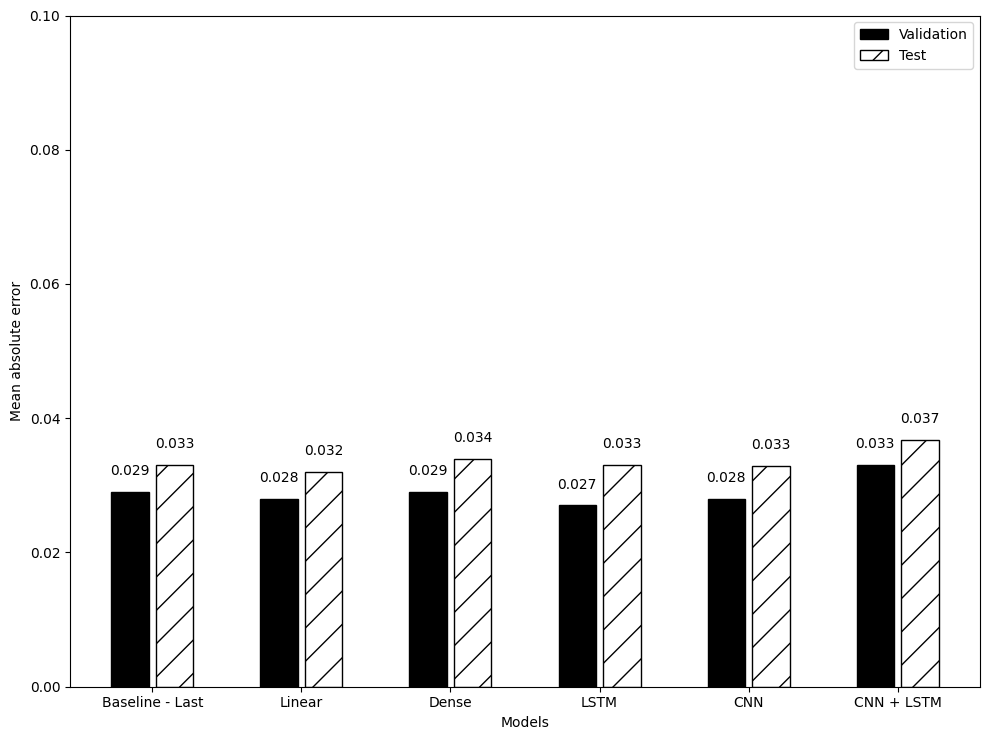

In [23]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-step model 

### CNN 

#### Build a CNN model. Set the kernel width to 3.

In [27]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['NO2'])

In [28]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_conv_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 4s 6ms/step - loss: 0.0130 - mean_absolute_error: 0.0865 - val_loss: 0.0085 - val_mean_absolute_error: 0.0690
Epoch 2/50
413/413 [==============================] - 2s 5ms/step - loss: 0.0111 - mean_absolute_error: 0.0799 - val_loss: 0.0085 - val_mean_absolute_error: 0.0690
Epoch 3/50
413/413 [==============================] - 2s 4ms/step - loss: 0.0108 - mean_absolute_error: 0.0784 - val_loss: 0.0096 - val_mean_absolute_error: 0.0727
Epoch 4/50
413/413 [==============================] - 2s 4ms/step - loss: 0.0107 - mean_absolute_error: 0.0781 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700
Epoch 5/50
117/117 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0713


#### Plot its predictions

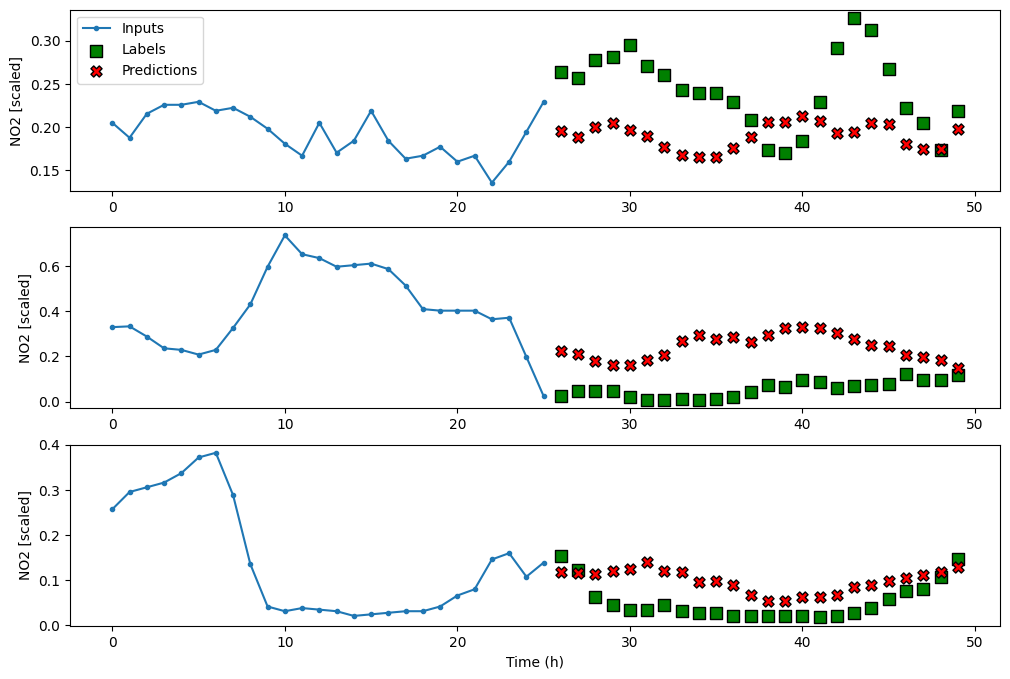

In [30]:
multi_conv_window.plot(ms_cnn_model)

### CNN + LSTM

In [32]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_conv_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 11s 17ms/step - loss: 0.0136 - mean_absolute_error: 0.0885 - val_loss: 0.0086 - val_mean_absolute_error: 0.0701
Epoch 2/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0113 - mean_absolute_error: 0.0807 - val_loss: 0.0095 - val_mean_absolute_error: 0.0723
Epoch 3/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0109 - mean_absolute_error: 0.0790 - val_loss: 0.0084 - val_mean_absolute_error: 0.0687
Epoch 4/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0107 - mean_absolute_error: 0.0782 - val_loss: 0.0084 - val_mean_absolute_error: 0.0681
Epoch 5/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0104 - mean_absolute_error: 0.0773 - val_loss: 0.0088 - val_mean_absolute_error: 0.0695
Epoch 6/50
117/117 [==============================] - 1s 6ms/step - loss: 0.0089 - mean_absolute_error: 0.0699


#### Plot predictions

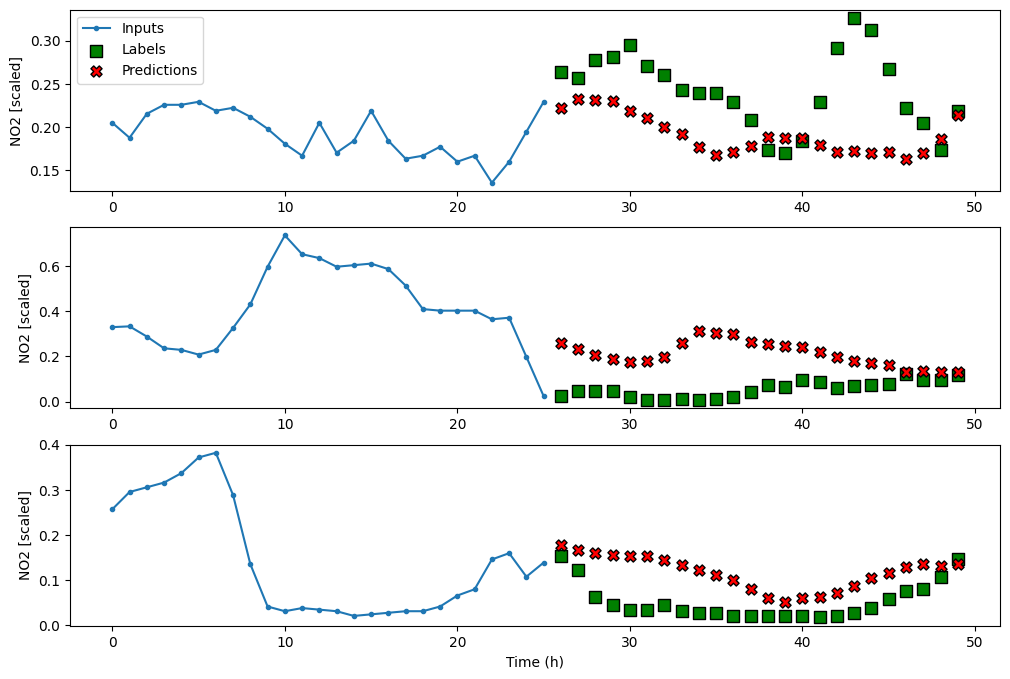

In [34]:
multi_conv_window.plot(ms_cnn_lstm_model)

#### Evaluate the model using the MAE and store the MAE

In [36]:
# Values obtained from chapter 15

ms_mae_val = [0.282, 0.282, 0.070, 0.071, 0.069]
ms_mae_test = [0.243, 0.244, 0.115, 0.114, 0.114]

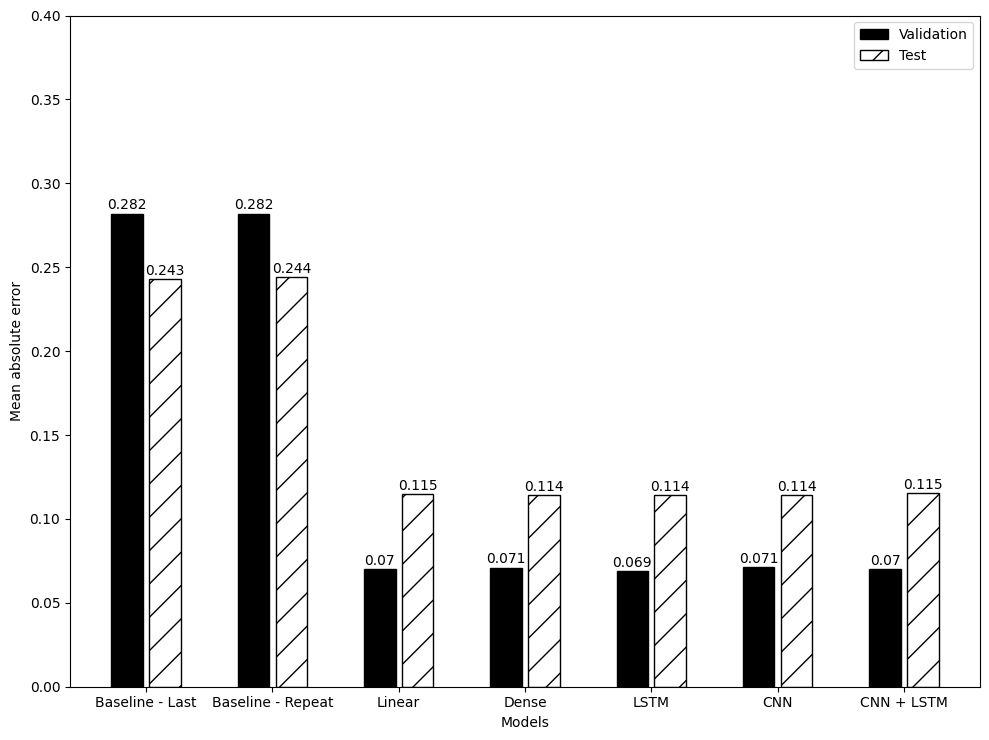

In [37]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

## Multi-output model
### CNN

#### Build a CNN model. Set the kernel width to 3.

In [40]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['NO2', 'TEMP'])

In [41]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 4s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0416 - val_loss: 0.0013 - val_mean_absolute_error: 0.0240
Epoch 2/50
413/413 [==============================] - 3s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0222 - val_loss: 0.0011 - val_mean_absolute_error: 0.0216
Epoch 3/50
413/413 [==============================] - 3s 6ms/step - loss: 9.6339e-04 - mean_absolute_error: 0.0205 - val_loss: 0.0011 - val_mean_absolute_error: 0.0205
Epoch 4/50
413/413 [==============================] - 2s 6ms/step - loss: 9.2195e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0011 - val_mean_absolute_error: 0.0201
Epoch 5/50
413/413 [==============================] - 2s 6ms/step - loss: 8.9132e-04 - mean_absolute_error: 0.0193 - val_loss: 0.0011 - val_mean_absolute_error: 0.0201
Epoch 6/50
413/413 [==============================] - 2s 5ms/step - loss: 8.7465e-04 - mean_absolute_error: 0.0190 - val_loss: 0.0011 - val_mean_absolute_error: 0.0197


#### Plot its predictions

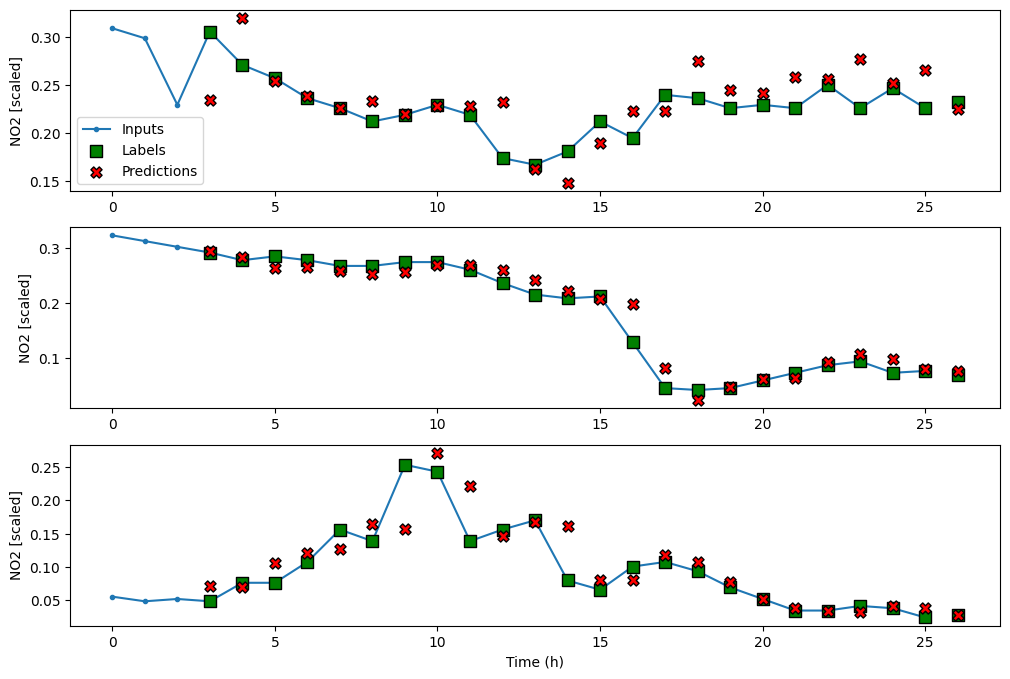

In [43]:
wide_mo_conv_window.plot(mo_cnn_model)

### CNN + LSTM

In [45]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
413/413 [==============================] - 12s 18ms/step - loss: 0.0087 - mean_absolute_error: 0.0572 - val_loss: 0.0017 - val_mean_absolute_error: 0.0295
Epoch 2/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0271 - val_loss: 0.0013 - val_mean_absolute_error: 0.0245
Epoch 3/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0232 - val_loss: 0.0012 - val_mean_absolute_error: 0.0225
Epoch 4/50
413/413 [==============================] - 7s 16ms/step - loss: 0.0010 - mean_absolute_error: 0.0215 - val_loss: 0.0012 - val_mean_absolute_error: 0.0216
Epoch 5/50
413/413 [==============================] - 6s 15ms/step - loss: 9.6545e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0011 - val_mean_absolute_error: 0.0204
Epoch 6/50
413/413 [==============================] - 6s 15ms/step - loss: 9.2855e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0011 - val_mean_absolute_error: 0.0203
E

#### Plot its predictions

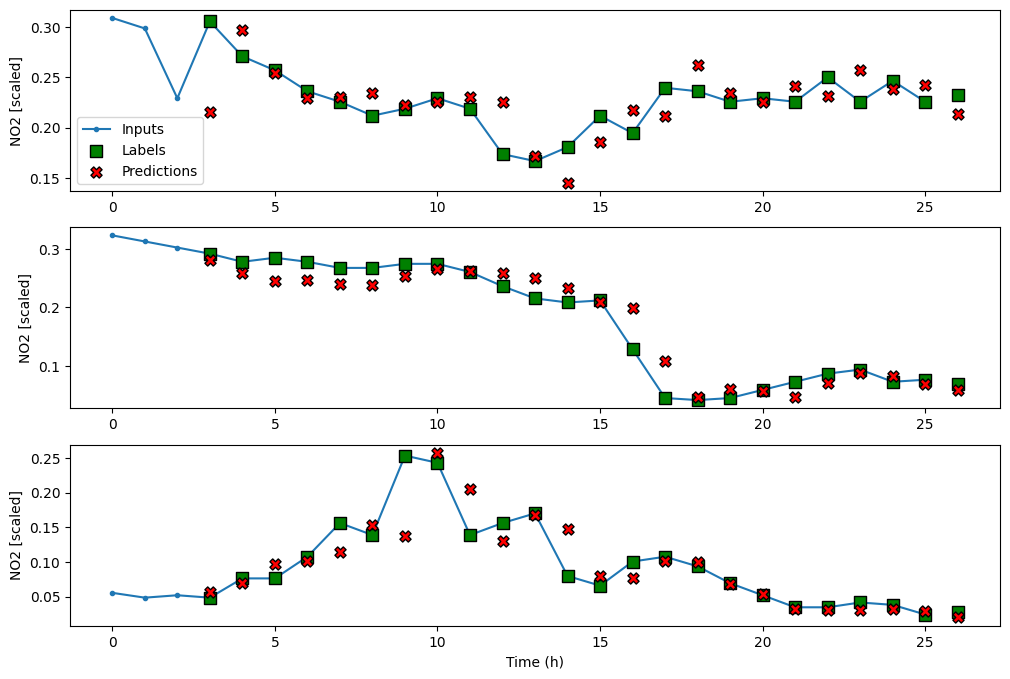

In [47]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

#### Evaluate the model using the MAE and store the MAE.

In [49]:
# Values from chapter 15

mo_mae_val = [0.021, 0.020, 0.020, 0.019]
mo_mae_test = [0.025, 0.023, 0.025, 0.022]

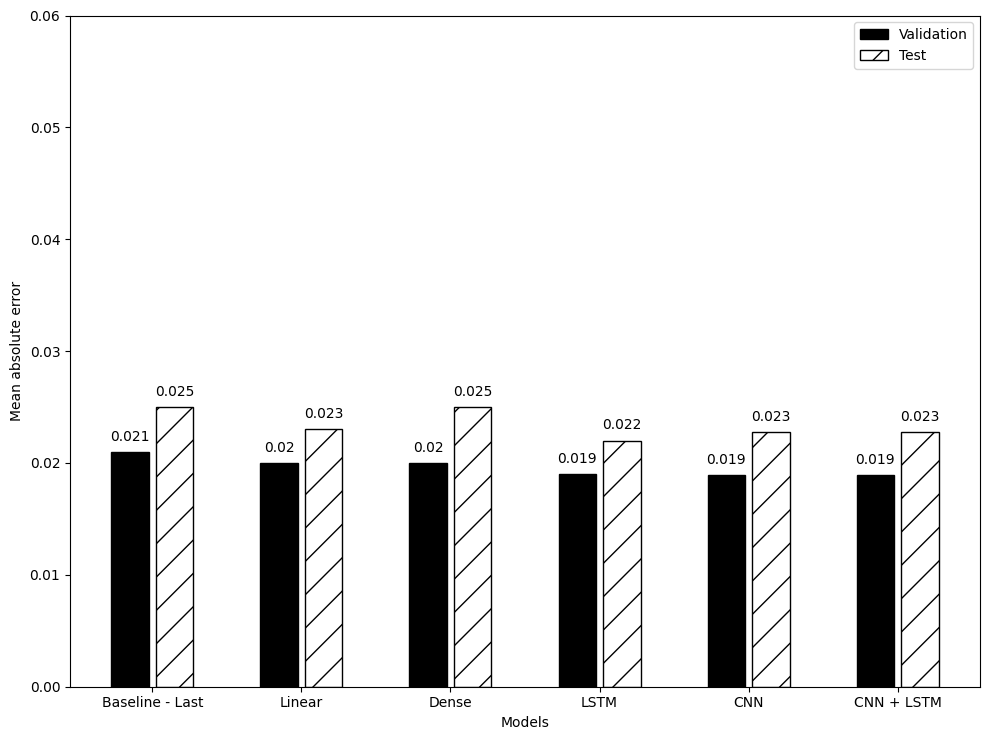

In [50]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()